# <span style="color:red"> **A. Gradient Boosting** </span>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset = pd.read_csv('/kaggle/input/creditgame-train/CreditGame_Train.csv')
dataset.head()

,ID_TRAIN,NB_EMPT,R_ATD,DUREE,PRT_VAL,AGE_D,REV_BT,REV_NET,TYP_RES,ST_EMPL,...,NB_DEL_90,MNT_PASS,MNT_ACT,MNT_AUT_REN,MNT_UTIL_REN,NB_SATI,TYP_FIN,MNT_DEMANDE,DEFAULT,PROFIT_LOSS
0,1,2,0.28,3,1.00,28.0,30000,27000,P,P,...,0,31645,51423,3500,3288,8,AUTO,19100,0,955.0
1,2,1,0.20,2,0.42,77.0,42000,24000,L,R,...,0,72,82890,4000,395,5,AUTO,21500,0,1075.0
2,3,1,0.29,5,0.86,48.0,87000,75000,P,R,...,0,218979,220951,10500,6186,3,AUTO,14300,0,715.0
3,4,1,0.07,4,0.92,26.0,89000,77000,P,R,...,0,301166,413887,2000,1687,5,AUTO,19500,0,975.0
4,5,1,0.19,5,1.00,39.0,86000,55000,P,P,...,0,302280,302544,46500,1740,5,AUTO,9000,0,450.0


In [3]:
# Handling ST_EMPL missing values
dataset['ST_EMPL'] = dataset['ST_EMPL'].fillna("O")


# Creation of two variables: RMU and RTS
# RMU : ratio between the amount of revolving credit used and the authorized amount of revolving credit
# RTS : the ratio between the number of satisfactory transactions and the total number of transactions 
dataset['RMU'] = np.where(dataset['MNT_AUT_REN'] == 0, 0, 
                          dataset['MNT_UTIL_REN'] / dataset['MNT_AUT_REN'])

dataset['RTS'] = np.where(dataset['NB_OPER'] == 0, 0, 
                          dataset['NB_SATI'] / dataset['NB_OPER'])


# Dummies for ST_EMPL and TYP_RES
dataset = pd.get_dummies(dataset, columns=['ST_EMPL'], prefix='ST_EMPL', 
                         dtype=int, drop_first = True)

dataset = pd.get_dummies(dataset, columns=['TYP_RES'], prefix='TYP_RES', 
                         dtype=int, drop_first = True)

In [4]:
# Train (60%), validation (20%) and test (20%) split 
X = dataset.iloc[:, dataset.columns != 'DEFAULT']
y = dataset[['DEFAULT']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=1234)


# Imputation of missing AGE values using median
med_age = X_train['AGE_D'].median()
X_train['AGE_D'] = X_train['AGE_D'].fillna(med_age)
X_valid['AGE_D'] = X_valid['AGE_D'].fillna(med_age)
X_test['AGE_D'] = X_test['AGE_D'].fillna(med_age)

# <span style="color:purple"> **1 - Model selection** </span>

## <span style="color:blue"> **1.1. Model with original variables** </span>

In [5]:
# Drop unnecessary columns
columns_to_drop1 = ['ID_TRAIN', 'REV_NET', 'NB_INTR_1M', 'TYP_FIN', 'RMU', 'RTS', 'PROFIT_LOSS'] 

X_train_cl = X_train.drop(columns=columns_to_drop1)
X_valid_cl= X_valid.drop(columns=columns_to_drop1)
X_test_cl = X_test.drop(columns=columns_to_drop1)

y_train = np.ravel(y_train)

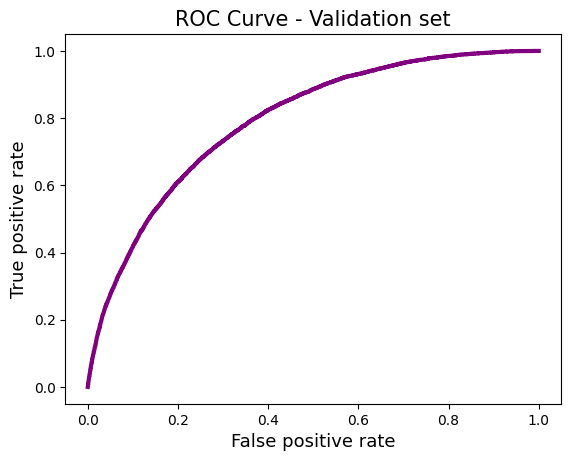

In [6]:
#  These parameters below were chosen arbitrarily.
gbc = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, random_state=100)
gbc.fit(X_train_cl, y_train)


# Class probabilities prediction - validation set
p_hat_val = gbc.predict_proba(X_valid_cl)

# P(DEFAULT = 1) predictions
p_hat_val_class1 = p_hat_val[:,1]


# False positive and true positive rates and the corresponding thresholds (cutoffs)
fpr, tpr, thresholds = metrics.roc_curve(y_valid, p_hat_val_class1)


# Displaying ROC curve (validation set)
ROC = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr)
ROC.plot(linewidth=3, color='purple')
plt.title('ROC Curve - Validation set', fontsize = 15)
plt.xlabel("False positive rate", fontsize = 13)
plt.ylabel("True positive rate", fontsize = 13)
plt.show()

<font size="4"> The optimal cutoff is the point on the ROC curve nearest to the upper-left corner (coordinates: (0,1)), as it represents the scenario where both the true positive rate and false positive rate are at their best possible values. It is known that there is a trade-off between these two metrics; **an improvement in one directly results in a deterioration of the other** : as the true positive rate increases, so does the false positive rate, and vice versa. </font>   

<font size="4"> As mentioned in the preamble of this project, the two metrics that are particularly important to monitor are the false positive rate and the false negative rate (**false negative rate = 1 - true positive rate**). The function below returns the cutoff that minimizes both the false positive rate and the false negative rate. </font>

In [7]:
def find_optimal_cutoff(model, X, y):

    fpr, tpr, thresholds = metrics.roc_curve(y, model.predict_proba(X)[:, 1])
    
    # fnr stands for false negative rate  
    fnr = 1 - tpr

    min_distance = float('inf')
    best_cutoff = None
    for i, threshold in enumerate(thresholds):
        distance = np.sqrt((fnr[i])**2 + (fpr[i])**2)
        if distance < min_distance:
            min_distance = distance
            best_cutoff = threshold

    return best_cutoff

In [8]:
cut_opt = find_optimal_cutoff(gbc, X_valid_cl, y_valid)
print(cut_opt)

# Class prediction - validation set
y_val_hat= [1 if prob > cut_opt else 0 for prob in p_hat_val_class1]

# Confusion matrix - validation set
conf_mat_val = metrics.confusion_matrix(y_valid, y_val_hat)
conf_mat_val

0.05040517245461595


array([[108427,  43590],
       [  2239,   5744]])

<font size="3">The optimal threshold is approximatively 0.0504. It means that all observations with predicted probability P(DEFAULT = 1) > 0.0504 will be considered at risk of default.</font>

In [9]:
fpr_val = conf_mat_val[0,1] / (conf_mat_val[0,0] + conf_mat_val[0,1])
fnr_val = conf_mat_val[1,0] / (conf_mat_val[1,0] + conf_mat_val[1,1])

print(f'AUC: {roc_auc_score(y_valid, y_val_hat)}')
print(f'Accuracy: {metrics.accuracy_score(y_valid, y_val_hat) * 100:.2f}%')
print("False positive rate: {:.2f}%".format(fpr_val * 100))
print("False negative rate: {:.2f}%".format(fnr_val * 100))
print(f'Precision: {metrics.precision_score(y_valid, y_val_hat) * 100:.2f}%')
print(f'Sensivity (true positive rate) : {metrics.recall_score(y_valid, y_val_hat) * 100:.2f}%')
print(f'Specificity (true negative rate): {metrics.recall_score(y_valid, y_val_hat, pos_label=0) * 100:.2f}%')

print("\n")
print("\n")
print("\033[4m" + "Classification report - Validation set" + "\033[0m")
print("\n")
print(metrics.classification_report(y_valid, y_val_hat))

AUC: 0.7163923767068876
Accuracy: 71.36%
False positive rate: 28.67%
False negative rate: 28.05%
Precision: 11.64%
Sensivity (true positive rate) : 71.95%
Specificity (true negative rate): 71.33%




Classification report - Validation set


              precision    recall  f1-score   support

           0       0.98      0.71      0.83    152017
           1       0.12      0.72      0.20      7983

    accuracy                           0.71    160000
   macro avg       0.55      0.72      0.51    160000
weighted avg       0.94      0.71      0.79    160000



- <font size="3"> The accuracy rate on the validation set is 71.36%. This means that, with a cutoff of 0.0504, our model correctly classified 71% of the 160 000 observations in the validation set.</font> 
    
- <font size="3"> Out of the 7 983 risky loans, the model was able to identify and correctly classify 5 744 of them, which is quite encouraging (a false negative rate of 28.05%). However, our model incorrectly identified 43 590 safe loans as risky (a false positive rate of 28.67%), which is a bit more preoccupying. </font>

Text(0.5, 269.55555555555554, 'Predicted labels')

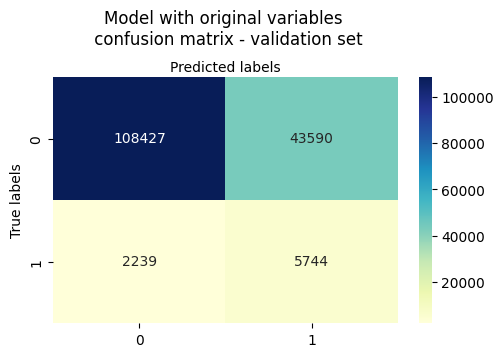

In [10]:
class_names=[0,1]
fig, ax = plt.subplots(figsize=(5,3))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Heatmap
sns.heatmap(pd.DataFrame(conf_mat_val), annot = True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Model with original variables \n confusion matrix - validation set', y=1.1)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')

In [11]:
temp_gbc = pd.DataFrame()
temp_gbc['y_valid'] = y_valid
temp_gbc['PROFIT_LOSS'] = X_valid['PROFIT_LOSS']
temp_gbc['y_pred'] = y_val_hat

In [12]:
temp_gbc['prof_pred'] = -9000
temp_gbc.loc[(temp_gbc['y_valid'] == 0) & (temp_gbc['y_pred'] == 0), 'prof_pred'] = temp_gbc['PROFIT_LOSS']
temp_gbc.loc[(temp_gbc['y_valid'] == 1) & (temp_gbc['y_pred'] == 1), 'prof_pred'] = 0
temp_gbc.loc[(temp_gbc['y_valid'] == 1) & (temp_gbc['y_pred'] == 0), 'prof_pred'] = temp_gbc['PROFIT_LOSS']
temp_gbc.loc[(temp_gbc['y_valid'] == 0) & (temp_gbc['y_pred'] == 1), 'prof_pred'] = 0

In [13]:
prof_pre_val_gbc = temp_gbc['PROFIT_LOSS'].sum()
prof_post_val_gbc = temp_gbc['prof_pred'].sum()
print("Total profit made without model (Validation set) : ${:,.2f}".format(prof_pre_val_gbc))
print("Total profit made with model (Validation set) : ${:,.2f}".format(prof_post_val_gbc))

Total profit made without model (Validation set) : $41,346,911.56
Total profit made with model (Validation set) : $87,044,530.63


## <span style="color:blue"> **1.2. Model with newly created variables** </span>

In [14]:
# Drop unnecessary columns
columns_to_drop2 = ['ID_TRAIN', 'REV_NET', 'NB_INTR_1M', 'MNT_AUT_REN', 'MNT_UTIL_REN', 
                    'TYP_FIN', 'NB_OPER', 'NB_SATI', 'PROFIT_LOSS'] 

X_train_cl2 = X_train.drop(columns=columns_to_drop2)
X_valid_cl2 = X_valid.drop(columns=columns_to_drop2)
X_test_cl2 = X_test.drop(columns=columns_to_drop2)

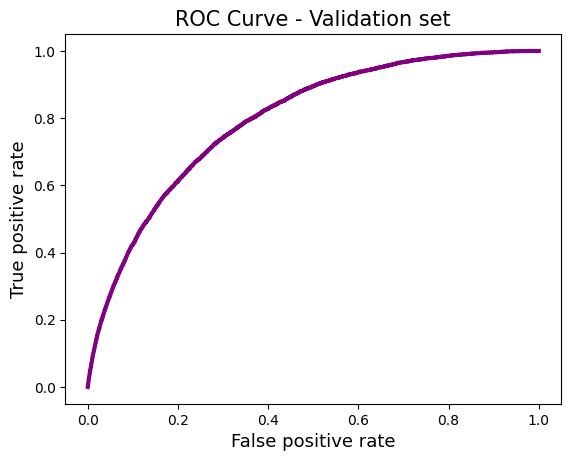

In [15]:
#  These parameters below were chosen arbitrarily.
gbc2 = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, random_state=100)
gbc2.fit(X_train_cl2, y_train)


# Class probabilities prediction - validation set
p_hat_val_mod2 = gbc2.predict_proba(X_valid_cl2)

# P(DEFAULT = 1) predictions
p_hat_val_class1_mod2 = p_hat_val_mod2[:,1]


# False positive and true positive rates and the corresponding thresholds (cutoffs)
fpr, tpr, thresholds = metrics.roc_curve(y_valid, p_hat_val_class1_mod2)


# Displaying ROC curve (validation set)
ROC = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr)
ROC.plot(linewidth=3, color='purple')
plt.title('ROC Curve - Validation set', fontsize = 15)
plt.xlabel("False positive rate", fontsize = 13)
plt.ylabel("True positive rate", fontsize = 13)
plt.show()

In [16]:
cut_opt_mod2 = find_optimal_cutoff(gbc2, X_valid_cl2, y_valid)
print(cut_opt_mod2)

# Class prediction - validation set
y_val_hat_mod2 = [1 if prob > cut_opt_mod2 else 0 for prob in p_hat_val_class1_mod2]

# Confusion matrix - validation set
conf_mat_val_mod2 = metrics.confusion_matrix(y_valid, y_val_hat_mod2)
conf_mat_val_mod2

0.04927531795074824


array([[107769,  44248],
       [  2126,   5857]])

In [17]:
fpr_val_mod2 = conf_mat_val_mod2[0,1] / (conf_mat_val_mod2[0,0] + conf_mat_val_mod2[0,1])
fnr_val_mod2 = conf_mat_val_mod2[1,0] / (conf_mat_val_mod2[1,0] + conf_mat_val_mod2[1,1])

print(f'AUC: {metrics.roc_auc_score(y_valid, y_val_hat_mod2)}')
print(f'Accuracy: {metrics.accuracy_score(y_valid, y_val_hat_mod2) * 100:.2f}%')
print("False positive rate: {:.2f}%".format(fpr_val_mod2 * 100))
print("False negative rate: {:.2f}%".format(fnr_val_mod2 * 100))
print(f'Precision: {metrics.precision_score(y_valid, y_val_hat_mod2) * 100:.2f}%')
print(f'Sensivity (true positive rate) : {metrics.recall_score(y_valid, y_val_hat_mod2) * 100:.2f}%')
print(f'Specificity (true negative rate): {metrics.recall_score(y_valid, y_val_hat_mod2, pos_label=0) * 100:.2f}%')

print("\n")
print("\n")
print("\033[4m" + "Classification report - Validation set" + "\033[0m")
print("\n")
print(metrics.classification_report(y_valid, y_val_hat_mod2))

AUC: 0.7213056848469147
Accuracy: 71.02%
False positive rate: 29.11%
False negative rate: 26.63%
Precision: 11.69%
Sensivity (true positive rate) : 73.37%
Specificity (true negative rate): 70.89%




Classification report - Validation set


              precision    recall  f1-score   support

           0       0.98      0.71      0.82    152017
           1       0.12      0.73      0.20      7983

    accuracy                           0.71    160000
   macro avg       0.55      0.72      0.51    160000
weighted avg       0.94      0.71      0.79    160000



Text(0.5, 269.55555555555554, 'Predicted labels')

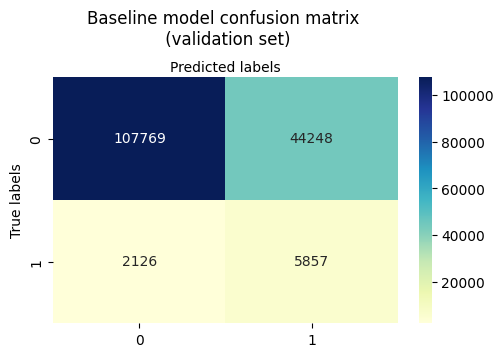

In [18]:
class_names=[0,1]
fig, ax = plt.subplots(figsize=(5,3))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Heatmap
sns.heatmap(pd.DataFrame(conf_mat_val_mod2), annot = True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Baseline model confusion matrix \n (validation set)', y=1.1)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')

In [19]:
temp_gbc2_val = pd.DataFrame()
temp_gbc2_val['y_valid'] = y_valid
temp_gbc2_val['PROFIT_LOSS'] = X_valid['PROFIT_LOSS']
temp_gbc2_val['y_pred'] = y_val_hat_mod2

In [20]:
temp_gbc2_val['prof_pred'] = -9000
temp_gbc2_val.loc[(temp_gbc2_val['y_valid'] == 0) & (temp_gbc2_val['y_pred'] == 0), 'prof_pred'] = temp_gbc2_val['PROFIT_LOSS']
temp_gbc2_val.loc[(temp_gbc2_val['y_valid'] == 1) & (temp_gbc2_val['y_pred'] == 1), 'prof_pred'] = 0
temp_gbc2_val.loc[(temp_gbc2_val['y_valid'] == 1) & (temp_gbc2_val['y_pred'] == 0), 'prof_pred'] = temp_gbc2_val['PROFIT_LOSS']
temp_gbc2_val.loc[(temp_gbc2_val['y_valid'] == 0) & (temp_gbc2_val['y_pred'] == 1), 'prof_pred'] = 0

In [21]:
prof_pre_val_gbc2 = temp_gbc2_val['PROFIT_LOSS'].sum()
prof_post_val_gbc2 = temp_gbc2_val['prof_pred'].sum()
print("Total profit made without model (Validation set) : ${:,.2f}".format(prof_pre_val_gbc2))
print("Total profit made with model (Validation set) : ${:,.2f}".format(prof_post_val_gbc2))

Total profit made without model (Validation set) : $41,346,911.56
Total profit made with model (Validation set) : $87,999,004.80


# <span style="color:purple"> **2. Test Performance** </span>

In [22]:
# Class probabilities prediction - Test set
p_hat_test_mod2 = gbc2.predict_proba(X_test_cl2)

# P(DEFAULT = 1) predictions
p_hat_test_class1_mod2 = p_hat_test_mod2[:,1]

# False positive and true positive rates and the corresponding thresholds (cutoffs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, p_hat_test_class1_mod2)


# Class prediction
y_test_hat_mod2 = [1 if prob > cut_opt_mod2 else 0 for prob in p_hat_test_class1_mod2]


# Confusion matrix - test set
conf_mat_test_mod2 = metrics.confusion_matrix(y_test, y_test_hat_mod2)
conf_mat_test_mod2

array([[107801,  44303],
       [  2187,   5709]])

In [23]:
fpr_test_mod2 = conf_mat_test_mod2[0,1] / (conf_mat_test_mod2[0,0] + conf_mat_test_mod2[0,1])
fnr_test_mod2 = conf_mat_test_mod2[1,0] / (conf_mat_test_mod2[1,0] + conf_mat_test_mod2[1,1])

print(f'AUC: {metrics.roc_auc_score(y_test, y_test_hat_mod2)}')
print(f'Accuracy: {metrics.accuracy_score(y_test, y_test_hat_mod2) * 100:.2f}%')
print("False positive rate: {:.2f}%".format(fpr_test_mod2 * 100))
print("False negative rate: {:.2f}%".format(fnr_test_mod2 * 100))
print(f'Precision: {metrics.precision_score(y_test, y_test_hat_mod2) * 100:.2f}%')
print(f'Sensivity (true positive rate) : {metrics.recall_score(y_test, y_test_hat_mod2) * 100:.2f}%')
print(f'Specificity (true negative rate): {metrics.recall_score(y_test, y_test_hat_mod2, pos_label=0) * 100:.2f}%')

print("\n")
print("\n")
print("\033[4m" + "Classification report - Test set" + "\033[0m")
print("\n")
print(metrics.classification_report(y_test, y_test_hat_mod2))

AUC: 0.7158782496762334
Accuracy: 70.94%
False positive rate: 29.13%
False negative rate: 27.70%
Precision: 11.42%
Sensivity (true positive rate) : 72.30%
Specificity (true negative rate): 70.87%




Classification report - Test set


              precision    recall  f1-score   support

           0       0.98      0.71      0.82    152104
           1       0.11      0.72      0.20      7896

    accuracy                           0.71    160000
   macro avg       0.55      0.72      0.51    160000
weighted avg       0.94      0.71      0.79    160000



Text(0.5, 269.55555555555554, 'Predicted labels')

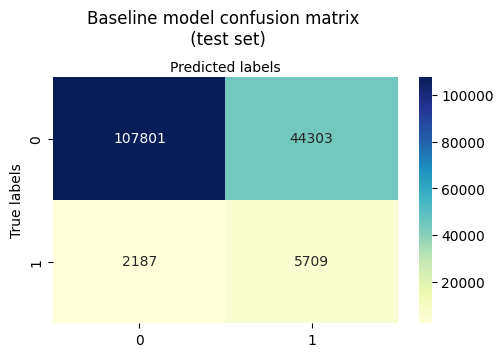

In [24]:
class_names=[0,1]
fig, ax = plt.subplots(figsize=(5,3))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Heatmap
sns.heatmap(pd.DataFrame(conf_mat_test_mod2), annot = True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Baseline model confusion matrix \n (test set)', y=1.1)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')

In [25]:
temp_gbc2_test = pd.DataFrame()
temp_gbc2_test['y_test'] = y_test
temp_gbc2_test['PROFIT_LOSS'] = X_test['PROFIT_LOSS']
temp_gbc2_test['y_pred'] = y_test_hat_mod2

In [26]:
temp_gbc2_test['prof_pred'] = -9000
temp_gbc2_test.loc[(temp_gbc2_test['y_test'] == 0) & (temp_gbc2_test['y_pred'] == 0), 'prof_pred'] = temp_gbc2_test['PROFIT_LOSS']
temp_gbc2_test.loc[(temp_gbc2_test['y_test'] == 1) & (temp_gbc2_test['y_pred'] == 1), 'prof_pred'] = 0
temp_gbc2_test.loc[(temp_gbc2_test['y_test'] == 1) & (temp_gbc2_test['y_pred'] == 0), 'prof_pred'] = temp_gbc2_test['PROFIT_LOSS']
temp_gbc2_test.loc[(temp_gbc2_test['y_test'] == 0) & (temp_gbc2_test['y_pred'] == 1), 'prof_pred'] = 0

In [27]:
prof_pre_test_gbc2 = temp_gbc2_test['PROFIT_LOSS'].sum()
prof_post_test_gbc2 = temp_gbc2_test['prof_pred'].sum()
print("Total profit made without model (Test set) : ${:,.2f}".format(prof_pre_test_gbc2))
print("Total profit made with model (Test set) : ${:,.2f}".format(prof_post_test_gbc2))

Total profit made without model (Test set) : $43,693,920.80
Total profit made with model (Test set) : $88,171,626.44


<font size="4"> Although the cutoff choice affects directly the false positive and false negative rates, adjusting it to improve one will inevitably deteriorate the other. Its final value will depend on one's tolerance to the risk of incorrectly classifying loans as at risk versus the risk of classifying risky loans as safe. However, before determining the optimal cutoff choice, we will first attempt to optimize the model parameters, which have so far been chosen arbitrarily. </font>

# <span style="color:purple"> **3. Tuning parameters** </span>

<font size="3"> There are several ways to tune model parameters. A very efficient way is to carry out a grid search combined with cross-validation. GradientBoostingClassifier has several parameters but for many data scientists, the most crucial ones are: n_estimators, learning_rate, and max_depth. n_estimators indicates the number of boosting stages to perform, learning_rate controls the contribution of each individual tree to the overall model and max_depth limits the number of nodes in each tree. (cf : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)</font>      

<font size="3"> However, given the size of our dataset, the impact of the previously listed parameters on execution time and the very principle of cross-validation, this process would just have been extremely time consuming. So instead of tuning the parameters using cross validation </font>     

In [28]:
# Parameters
num_estim = [100, 200, 300, 500]
depth = [3, 5]

results = []

for num in num_estim :
    for m_d in depth :
        
        # Training
        gbc_tune = GradientBoostingClassifier(n_estimators = num, learning_rate = 0.05,
                                              max_depth = m_d, random_state = 100)
        gbc_tune.fit(X_train_cl2, y_train)

        # Class probabilities prediction - validation set
        p_hat_val_gbc_tune = gbc_tune.predict_proba(X_valid_cl2)

        # P(DEFAULT = 1) predictions
        p_hat_val_class1_gbc_tune = p_hat_val_gbc_tune[:,1]

        cut_opt_tune = find_optimal_cutoff(gbc_tune, X_valid_cl2, y_valid)

        # Class prediction - validation set
        y_val_hat_gbc_tune = [1 if prob > cut_opt_tune else 0 for prob in p_hat_val_class1_gbc_tune]

        # Confusion matrix
        fpr_val_gbc_tune = 0
        fnr_val_gbc_tune = 0

        conf_mat_val_gbc_tune = metrics.confusion_matrix(y_valid, y_val_hat_gbc_tune)
        fpr_val_gbc_tune = conf_mat_val_gbc_tune[0,1] / (conf_mat_val_gbc_tune[0,0] + conf_mat_val_gbc_tune[0,1])
        fnr_val_gbc_tune = conf_mat_val_gbc_tune[1,0] / (conf_mat_val_gbc_tune[1,0] + conf_mat_val_gbc_tune[1,1])


        results.append({
                'n estimators': num,
                'max depth ' : m_d,
                'AUC': roc_auc_score(y_valid, y_val_hat_gbc_tune),
                'Accuracy' : metrics.accuracy_score(y_valid, y_val_hat_gbc_tune),
                'False positive rate' : fpr_val_gbc_tune,
                'False negative rate' : fnr_val_gbc_tune
            })


results = pd.DataFrame(results)
results = results.sort_values(by='AUC', ascending = False)
results

,n estimators,max depth,AUC,Accuracy,False positive rate,False negative rate
6,500,3,0.722642,0.706275,0.295539,0.259176
4,300,3,0.721306,0.710163,0.291073,0.266316
5,300,5,0.721161,0.709775,0.291487,0.266191
7,500,5,0.721066,0.722900,0.276897,0.280972
3,200,5,0.720051,0.709019,0.292204,0.267694
2,200,3,0.718637,0.713888,0.286639,0.276087
1,100,5,0.716881,0.704688,0.296664,0.269573
0,100,3,0.711938,0.705894,0.294776,0.281348


In [29]:
# The model whose parameters yields to the best performance
best_model_gbc = GradientBoostingClassifier(n_estimators = 500, learning_rate = 0.05, max_depth = 3, random_state = 100)
best_model_gbc.fit(X_train_cl2, y_train)


# Class probabilities predictions on the test set using the best model
p_hat_test_best_gbc = best_model_gbc.predict_proba(X_test_cl2)

# P(DEFAULT = 1) predictions
p_hat_test_class1_best_gbc = p_hat_test_best_gbc[:,1]

In [30]:
cut_opt_best_mod = find_optimal_cutoff(best_model_gbc, X_test_cl2, y_test)
print(cut_opt_best_mod)

# Class prediction - validation set
y_test_hat_best_gbc = [1 if prob > cut_opt_best_mod else 0 for prob in p_hat_test_class1_best_gbc]

# Confusion matrix - validation set
conf_mat_test_best_gbc = metrics.confusion_matrix(y_test, y_test_hat_best_gbc)
conf_mat_test_best_gbc

0.048804066211222304


array([[107736,  44368],
       [  2142,   5754]])

In [31]:
fpr_test_best_gbc = conf_mat_test_best_gbc[0,1] / (conf_mat_test_best_gbc[0,0] + conf_mat_test_best_gbc[0,1])
fnr_test_best_gbc = conf_mat_test_best_gbc[1,0] / (conf_mat_test_best_gbc[1,0] + conf_mat_test_best_gbc[1,1])

print(f'AUC: {metrics.roc_auc_score(y_test, y_test_hat_best_gbc)}')
print(f'Accuracy: {metrics.accuracy_score(y_test, y_test_hat_best_gbc) * 100:.2f}%')
print("False positive rate: {:.2f}%".format(fpr_test_best_gbc * 100))
print("False negative rate: {:.2f}%".format(fnr_test_best_gbc * 100))
print(f'Precision: {metrics.precision_score(y_test, y_test_hat_best_gbc) * 100:.2f}%')
print(f'Sensivity (true positive rate) : {metrics.recall_score(y_test, y_test_hat_best_gbc) * 100:.2f}%')
print(f'Specificity (true negative rate): {metrics.recall_score(y_test, y_test_hat_best_gbc, pos_label=0) * 100:.2f}%')

print("\n")
print("\n")
print("\033[4m" + "Classification report - GBC best model, Test set" + "\033[0m")
print("\n")
print(metrics.classification_report(y_test, y_test_hat_best_gbc))   

AUC: 0.7185141241546935
Accuracy: 70.93%
False positive rate: 29.17%
False negative rate: 27.13%
Precision: 11.48%
Sensivity (true positive rate) : 72.87%
Specificity (true negative rate): 70.83%




Classification report - GBC best model, Test set


              precision    recall  f1-score   support

           0       0.98      0.71      0.82    152104
           1       0.11      0.73      0.20      7896

    accuracy                           0.71    160000
   macro avg       0.55      0.72      0.51    160000
weighted avg       0.94      0.71      0.79    160000



In [32]:
temp_test_best_gbc = pd.DataFrame()
temp_test_best_gbc['y_test'] = y_test
temp_test_best_gbc['PROFIT_LOSS'] = X_test['PROFIT_LOSS']
temp_test_best_gbc['y_pred'] = y_test_hat_best_gbc

In [33]:
temp_test_best_gbc['prof_pred'] = -9000
temp_test_best_gbc.loc[(temp_test_best_gbc['y_test'] == 0) & (temp_test_best_gbc['y_pred'] == 0), 'prof_pred'] = temp_test_best_gbc['PROFIT_LOSS']
temp_test_best_gbc.loc[(temp_test_best_gbc['y_test'] == 1) & (temp_test_best_gbc['y_pred'] == 1), 'prof_pred'] = 0
temp_test_best_gbc.loc[(temp_test_best_gbc['y_test'] == 1) & (temp_test_best_gbc['y_pred'] == 0), 'prof_pred'] = temp_test_best_gbc['PROFIT_LOSS']
temp_test_best_gbc.loc[(temp_test_best_gbc['y_test'] == 0) & (temp_test_best_gbc['y_pred'] == 1), 'prof_pred'] = 0

In [34]:
prof_pre_test_best_gbc = temp_test_best_gbc['PROFIT_LOSS'].sum()
prof_post_test_best_gbc = temp_test_best_gbc['prof_pred'].sum()
print("Total profit made without model (Test set) : ${:,.2f}".format(prof_pre_test_best_gbc))
print("Total profit made with best GBC model (Test set) : ${:,.2f}".format(prof_post_test_best_gbc))

Total profit made without model (Test set) : $43,693,920.80
Total profit made with best GBC model (Test set) : $88,897,172.56


# <span style="color:red"> **B. Histogram-based Gradient Boosting** </span>

## <span style="color:purple"> **1. Training and validation** </span>

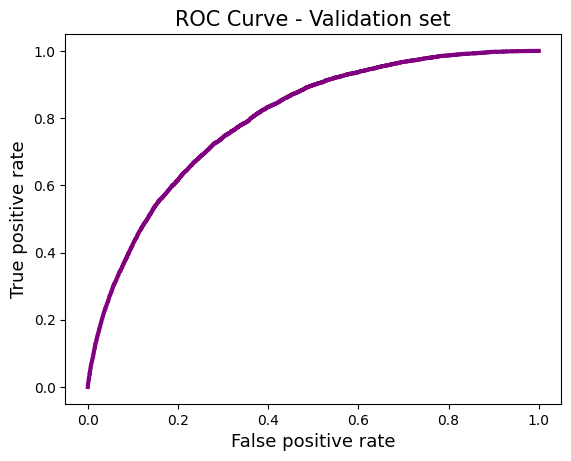

In [35]:
#  These parameters below were chosen arbitrarily
hgbc = HistGradientBoostingClassifier(learning_rate = 0.05, max_iter = 300, random_state = 1234, class_weight = 'balanced')
hgbc.fit(X_train_cl2, y_train)


# Class probabilities prediction - validation set
p_hat_val_hgbc = hgbc.predict_proba(X_valid_cl2)

# P(DEFAULT = 1) predictions
p_hat_val_class1_hgbc = p_hat_val_hgbc[:,1]


# False positive and true positive rates and the corresponding thresholds (cutoffs)
fpr, tpr, thresholds = metrics.roc_curve(y_valid, p_hat_val_class1_hgbc)


# Displaying ROC curve (validation set)
ROC = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr)
ROC.plot(linewidth=3, color='purple')
plt.title('ROC Curve - Validation set', fontsize = 15)
plt.xlabel("False positive rate", fontsize = 13)
plt.ylabel("True positive rate", fontsize = 13)
plt.show()

In [36]:
cut_opt_hgbc = find_optimal_cutoff(hgbc, X_valid_cl2, y_valid)
print(cut_opt_hgbc)

# Class prediction - validation set
y_val_hat_hgbc = [1 if prob > cut_opt_hgbc else 0 for prob in p_hat_val_class1_hgbc]

# Confusion matrix - validation set
conf_mat_val_hgbc = metrics.confusion_matrix(y_valid, y_val_hat_hgbc)
conf_mat_val_hgbc

0.509685735475933


array([[109536,  42481],
       [  2206,   5777]])

In [37]:
fpr_val_hgbc = conf_mat_val_hgbc[0,1] / (conf_mat_val_hgbc[0,0] + conf_mat_val_hgbc[0,1])
fnr_val_hgbc = conf_mat_val_hgbc[1,0] / (conf_mat_val_hgbc[1,0] + conf_mat_val_hgbc[1,1])

print(f'AUC: {metrics.roc_auc_score(y_valid, y_val_hat_hgbc)}')
print(f'Accuracy: {metrics.accuracy_score(y_valid, y_val_hat_hgbc) * 100:.2f}%')
print("False positive rate: {:.2f}%".format(fpr_val_hgbc * 100))
print("False negative rate: {:.2f}%".format(fnr_val_hgbc * 100))
print(f'Precision: {metrics.precision_score(y_valid, y_val_hat_hgbc) * 100:.2f}%')
print(f'Sensivity (true positive rate) : {metrics.recall_score(y_valid, y_val_hat_hgbc) * 100:.2f}%')
print(f'Specificity (true negative rate): {metrics.recall_score(y_valid, y_val_hat_hgbc, pos_label=0) * 100:.2f}%')

print("\n")
print("\n")
print("\033[4m" + "Classification report - Validation set" + "\033[0m")
print("\n")
print(metrics.classification_report(y_valid, y_val_hat_hgbc))

AUC: 0.7221068872111704
Accuracy: 72.07%
False positive rate: 27.94%
False negative rate: 27.63%
Precision: 11.97%
Sensivity (true positive rate) : 72.37%
Specificity (true negative rate): 72.06%




Classification report - Validation set


              precision    recall  f1-score   support

           0       0.98      0.72      0.83    152017
           1       0.12      0.72      0.21      7983

    accuracy                           0.72    160000
   macro avg       0.55      0.72      0.52    160000
weighted avg       0.94      0.72      0.80    160000



Text(0.5, 269.55555555555554, 'Predicted labels')

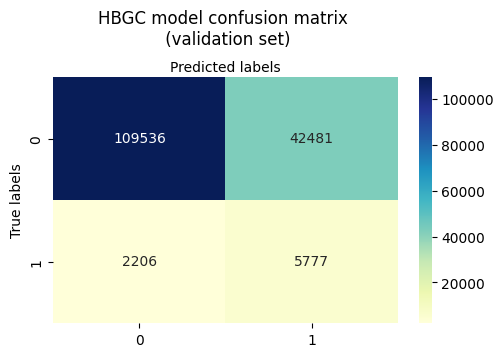

In [38]:
class_names=[0,1]
fig, ax = plt.subplots(figsize=(5,3))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Heatmap
sns.heatmap(pd.DataFrame(conf_mat_val_hgbc), annot = True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('HBGC model confusion matrix \n (validation set)', y=1.1)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')

In [39]:
temp_val_hgbc = pd.DataFrame()
temp_val_hgbc['y_valid'] = y_valid
temp_val_hgbc['PROFIT_LOSS'] = X_valid['PROFIT_LOSS']
temp_val_hgbc['y_pred'] = y_val_hat_hgbc

In [40]:
temp_val_hgbc['prof_pred'] = -9000
temp_val_hgbc.loc[(temp_val_hgbc['y_valid'] == 0) & (temp_val_hgbc['y_pred'] == 0), 'prof_pred'] = temp_val_hgbc['PROFIT_LOSS']
temp_val_hgbc.loc[(temp_val_hgbc['y_valid'] == 1) & (temp_val_hgbc['y_pred'] == 1), 'prof_pred'] = 0
temp_val_hgbc.loc[(temp_val_hgbc['y_valid'] == 1) & (temp_val_hgbc['y_pred'] == 0), 'prof_pred'] = temp_val_hgbc['PROFIT_LOSS']
temp_val_hgbc.loc[(temp_val_hgbc['y_valid'] == 0) & (temp_val_hgbc['y_pred'] == 1), 'prof_pred'] = 0

In [41]:
prof_pre_val_hgbc = temp_val_hgbc['PROFIT_LOSS'].sum()
prof_post_val_hgbc = temp_val_hgbc['prof_pred'].sum()
print("Total profit made without model (Validation set): ${:,.2f}".format(prof_pre_val_hgbc))
print("Total profit made with HGBC model (Validation set) : ${:,.2f}".format(prof_post_val_hgbc))

Total profit made without model (Validation set): $41,346,911.56
Total profit made with HGBC model (Validation set) : $88,822,092.34


## <span style="color:purple"> **2. Test Performance** </span>

In [42]:
# Class probabilities prediction - Test set
p_hat_test_hgbc = hgbc.predict_proba(X_test_cl2)

# P(DEFAULT = 1) predictions
p_hat_test_class1_hgbc = p_hat_test_hgbc[:,1]

# False positive and true positive rates and the corresponding thresholds (cutoffs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, p_hat_test_class1_hgbc)


# Class prediction
y_test_hat_hgbc = [1 if prob > cut_opt_hgbc else 0 for prob in p_hat_test_class1_hgbc]


# Confusion matrix - test set
conf_mat_test_hgbc = metrics.confusion_matrix(y_test, y_test_hat_hgbc)
conf_mat_test_hgbc

array([[109675,  42429],
       [  2264,   5632]])

In [43]:
fpr_test_hgbc = conf_mat_test_hgbc[0,1] / (conf_mat_test_hgbc[0,0] + conf_mat_test_hgbc[0,1])
fnr_test_hgbc = conf_mat_test_hgbc[1,0] / (conf_mat_test_hgbc[1,0] + conf_mat_test_hgbc[1,1])

print(f'AUC: {metrics.roc_auc_score(y_test, y_test_hat_hgbc)}')
print(f'Accuracy: {metrics.accuracy_score(y_test, y_test_hat_hgbc) * 100:.2f}%')
print("False positive rate: {:.2f}%".format(fpr_test_hgbc * 100))
print("False negative rate: {:.2f}%".format(fnr_test_hgbc * 100))
print(f'Precision: {metrics.precision_score(y_test, y_test_hat_hgbc) * 100:.2f}%')
print(f'Sensivity (true positive rate) : {metrics.recall_score(y_test, y_test_hat_hgbc) * 100:.2f}%')
print(f'Specificity (true negative rate): {metrics.recall_score(y_test, y_test_hat_hgbc, pos_label=0) * 100:.2f}%')

print("\n")
print("\n")
print("\033[4m" + "Classification report - Test set" + "\033[0m")
print("\n")
print(metrics.classification_report(y_test, y_test_hat_hgbc))

AUC: 0.7171626219217258
Accuracy: 72.07%
False positive rate: 27.89%
False negative rate: 28.67%
Precision: 11.72%
Sensivity (true positive rate) : 71.33%
Specificity (true negative rate): 72.11%




Classification report - Test set


              precision    recall  f1-score   support

           0       0.98      0.72      0.83    152104
           1       0.12      0.71      0.20      7896

    accuracy                           0.72    160000
   macro avg       0.55      0.72      0.52    160000
weighted avg       0.94      0.72      0.80    160000



Text(0.5, 269.55555555555554, 'Predicted labels')

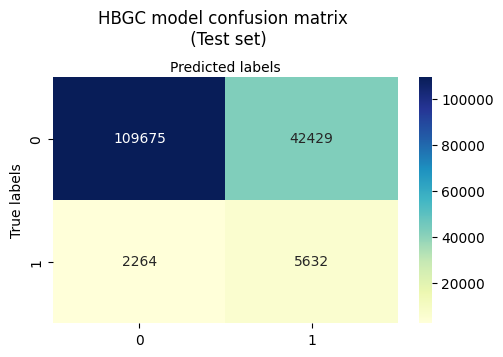

In [44]:
class_names=[0,1]
fig, ax = plt.subplots(figsize=(5,3))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Heatmap
sns.heatmap(pd.DataFrame(conf_mat_test_hgbc), annot = True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('HBGC model confusion matrix \n (Test set)', y=1.1)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')

In [45]:
temp_test_hgbc = pd.DataFrame()
temp_test_hgbc['y_test'] = y_test
temp_test_hgbc['PROFIT_LOSS'] = X_test['PROFIT_LOSS']
temp_test_hgbc['y_pred'] = y_test_hat_hgbc

In [46]:
temp_test_hgbc['prof_pred'] = -9000
temp_test_hgbc.loc[(temp_test_hgbc['y_test'] == 0) & (temp_test_hgbc['y_pred'] == 0), 'prof_pred'] = temp_test_hgbc['PROFIT_LOSS']
temp_test_hgbc.loc[(temp_test_hgbc['y_test'] == 1) & (temp_test_hgbc['y_pred'] == 1), 'prof_pred'] = 0
temp_test_hgbc.loc[(temp_test_hgbc['y_test'] == 1) & (temp_test_hgbc['y_pred'] == 0), 'prof_pred'] = temp_test_hgbc['PROFIT_LOSS']
temp_test_hgbc.loc[(temp_test_hgbc['y_test'] == 0) & (temp_test_hgbc['y_pred'] == 1), 'prof_pred'] = 0

In [47]:
prof_pre_test_hgbc = temp_test_hgbc['PROFIT_LOSS'].sum()
prof_post_test_hgbc = temp_test_hgbc['prof_pred'].sum()
print("Total profit made without model (Test set) : ${:,.2f}".format(prof_pre_test_hgbc))
print("Total profit made with HGBC model (Test set) : ${:,.2f}".format(prof_post_test_hgbc))

Total profit made without model (Test set) : $43,693,920.80
Total profit made with HGBC model (Test set) : $90,006,976.17


# <span style="color:purple"> **3. Tuning parameters** </span>

In [48]:
# Parameters
n_iter = [100, 200, 300, 500, 750, 1000]
learning_rates = [0.001, 0.05, 0.1, 0.5, 1]
depth = [3, 5, 7, 9, 11]

results = []

for it in n_iter :
    for lr in learning_rates : 
        for m_d in depth :
        
            # Training
            hgbc_tune = HistGradientBoostingClassifier(max_iter = it, learning_rate = lr, max_depth = m_d,
                                                       random_state = 1234, class_weight = 'balanced')
            hgbc_tune.fit(X_train_cl2, y_train)

            # Class probabilities prediction - validation set
            p_hat_val_hgbc_tune = hgbc_tune.predict_proba(X_valid_cl2)

            # P(DEFAULT = 1) predictions
            p_hat_val_class1_hgbc_tune = p_hat_val_hgbc_tune[:,1]

            cut_opt_tune = find_optimal_cutoff(hgbc_tune, X_valid_cl2, y_valid)

            # Class prediction - validation set
            y_val_hat_hgbc_tune = [1 if prob > cut_opt_tune else 0 for prob in p_hat_val_class1_hgbc_tune]

            # Confusion matrix
            fpr_val_tune = 0
            fnr_val_tune = 0

            conf_mat_val_tune = metrics.confusion_matrix(y_valid, y_val_hat_hgbc_tune)
            fpr_val_tune = conf_mat_val_tune[0,1] / (conf_mat_val_tune[0,0] + conf_mat_val_tune[0,1])
            fnr_val_tune = conf_mat_val_tune[1,0] / (conf_mat_val_tune[1,0] + conf_mat_val_tune[1,1])


            results.append({
                    'num iterations': it,
                    'learning rate' : lr,
                    'max depth ' : m_d,
                    'AUC': metrics.roc_auc_score(y_valid, y_val_hat_hgbc_tune),
                    'Accuracy' : metrics.accuracy_score(y_valid, y_val_hat_hgbc_tune),
                    'False positive rate' : fpr_val_tune,
                    'False negative rate' : fnr_val_tune
                })


results = pd.DataFrame(results)
results = results.sort_values(by='AUC', ascending = False)
results.head(10)

,num iterations,learning rate,max depth,AUC,Accuracy,False positive rate,False negative rate
89,500,0.10,11,0.723194,0.705631,0.296316,0.257297
14,100,0.10,11,0.723194,0.705631,0.296316,0.257297
114,750,0.10,11,0.723194,0.705631,0.296316,0.257297
64,300,0.10,11,0.723194,0.705631,0.296316,0.257297
39,200,0.10,11,0.723194,0.705631,0.296316,0.257297
139,1000,0.10,11,0.723194,0.705631,0.296316,0.257297
35,200,0.10,3,0.722683,0.713681,0.287317,0.267318
130,1000,0.05,3,0.722630,0.708619,0.292934,0.261806
105,750,0.05,3,0.722630,0.708619,0.292934,0.261806
80,500,0.05,3,0.722342,0.709538,0.291882,0.263435


In [49]:
# The model whose parameters yields to the best performance
best_model_hgbc = HistGradientBoostingClassifier(max_iter = 500, learning_rate = 0.1, max_depth = 11, 
                                                 random_state = 1234, class_weight = 'balanced')
best_model_hgbc.fit(X_train_cl2, y_train)


# Class probabilities predictions on the test set using the best model
p_hat_test_best_hgbc = best_model_hgbc.predict_proba(X_test_cl2)

# P(DEFAULT = 1) predictions
p_hat_test_class1_best_hgbc = p_hat_test_best_hgbc[:,1]

In [50]:
cut_opt_best_hgbc = find_optimal_cutoff(best_model_hgbc, X_test_cl2, y_test)
print(cut_opt_best_hgbc)

# Class prediction - validation set
y_test_hat_best_hgbc = [1 if prob > cut_opt_best_hgbc else 0 for prob in p_hat_test_class1_best_hgbc]

# Confusion matrix - validation set
conf_mat_test_best_hgbc = metrics.confusion_matrix(y_test, y_test_hat_best_hgbc)
conf_mat_test_best_hgbc

0.4947541295844788


array([[106637,  45467],
       [  2083,   5813]])

In [51]:
fpr_test_best_hgbc = conf_mat_test_best_hgbc[0,1] / (conf_mat_test_best_hgbc[0,0] + conf_mat_test_best_hgbc[0,1])
fnr_test_best_hgbc = conf_mat_test_best_hgbc[1,0] / (conf_mat_test_best_hgbc[1,0] + conf_mat_test_best_hgbc[1,1])

print(f'AUC: {metrics.roc_auc_score(y_test, y_test_hat_best_hgbc)}')
print(f'Accuracy: {metrics.accuracy_score(y_test, y_test_hat_best_hgbc) * 100:.2f}%')
print("False positive rate: {:.2f}%".format(fpr_test_best_hgbc * 100))
print("False negative rate: {:.2f}%".format(fnr_test_best_hgbc * 100))
print(f'Precision: {metrics.precision_score(y_test, y_test_hat_best_hgbc) * 100:.2f}%')
print(f'Sensivity (true positive rate) : {metrics.recall_score(y_test, y_test_hat_best_hgbc) * 100:.2f}%')
print(f'Specificity (true negative rate): {metrics.recall_score(y_test, y_test_hat_best_hgbc, pos_label=0) * 100:.2f}%')

print("\n")
print("\n")
print("\033[4m" + "Classification report - HGBC best model, Test set" + "\033[0m")
print("\n")
print(metrics.classification_report(y_test, y_test_hat_best_hgbc))

AUC: 0.7186375332912249
Accuracy: 70.28%
False positive rate: 29.89%
False negative rate: 26.38%
Precision: 11.34%
Sensivity (true positive rate) : 73.62%
Specificity (true negative rate): 70.11%




Classification report - HGBC best model, Test set


              precision    recall  f1-score   support

           0       0.98      0.70      0.82    152104
           1       0.11      0.74      0.20      7896

    accuracy                           0.70    160000
   macro avg       0.55      0.72      0.51    160000
weighted avg       0.94      0.70      0.79    160000



In [52]:
temp_test_best_hgbc = pd.DataFrame()
temp_test_best_hgbc['y_test'] = y_test
temp_test_best_hgbc['PROFIT_LOSS'] = X_test['PROFIT_LOSS']
temp_test_best_hgbc['y_pred'] = y_test_hat_best_hgbc

In [53]:
temp_test_best_hgbc['prof_pred'] = -9000
temp_test_best_hgbc.loc[(temp_test_best_hgbc['y_test'] == 0) & (temp_test_best_hgbc['y_pred'] == 0), 'prof_pred'] = temp_test_best_hgbc['PROFIT_LOSS']
temp_test_best_hgbc.loc[(temp_test_best_hgbc['y_test'] == 1) & (temp_test_best_hgbc['y_pred'] == 1), 'prof_pred'] = 0
temp_test_best_hgbc.loc[(temp_test_best_hgbc['y_test'] == 1) & (temp_test_best_hgbc['y_pred'] == 0), 'prof_pred'] = temp_test_best_hgbc['PROFIT_LOSS']
temp_test_best_hgbc.loc[(temp_test_best_hgbc['y_test'] == 0) & (temp_test_best_hgbc['y_pred'] == 1), 'prof_pred'] = 0

In [54]:
prof_pre_test_best_hgbc = temp_test_best_hgbc['PROFIT_LOSS'].sum()
prof_post_test_best_hgbc = temp_test_best_hgbc['prof_pred'].sum()
print("Total profit made without model (test set) : ${:,.2f}".format(prof_pre_test_best_hgbc))
print("Total profit made with model (best model on test set)  : ${:,.2f}".format(prof_post_test_best_hgbc))

Total profit made without model (test set) : $43,693,920.80
Total profit made with model (best model on test set)  : $88,891,174.02
